In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.environ import *

In [2]:
# rho_hat = df["Density"]
# q_hat = df["Flow"]
# print(max(q_hat))
# C_i = np.mean(sorted(q_hat)[-5:])
# print("C_i", C_i)
# K = len(rho_hat)


q_hat = np.load("flow_10sec_400m_1hr.npy")
print(np.max(q_hat))
rho_hat = np.load("density_10sec_400m_1hr.npy")
print(rho_hat.shape)
flattened_q_hat = q_hat.flatten()
print(max(flattened_q_hat))
flattened_rho_hat = rho_hat.flatten()
C_i = np.mean(np.sort(flattened_q_hat)[-5:])
print("C_i", C_i)
K = len(flattened_rho_hat)

1619.9142750000112
(360, 8)
1619.9142750000112
C_i 1533.7565549999936


In [3]:
model = ConcreteModel()
model.k = RangeSet(0, K - 1)

# Data parameters
model.rho_hat = Param(model.k, initialize={k: flattened_rho_hat[k] for k in range(K)})
model.q_hat = Param(model.k, initialize={k: flattened_q_hat[k] for k in range(K)})
model.C = Param(initialize=C_i)  # FIXED

# Variables to optimize
model.rho_crit = Var(bounds=(1e-2, max(flattened_rho_hat)), initialize=np.median(flattened_rho_hat))
model.V_free = Var(bounds=(10, 150), initialize=60)
model.a = Var(bounds=(0.01, 10), initialize=1.0)

# Smoothed piecewise flow function
def q_pred_expr(model, k):
    rho = model.rho_hat[k]
    rho_crit = model.rho_crit
    V_free = model.V_free
    a = model.a
    Q = rho * V_free * exp(-1/a * (rho/rho_crit)**a)
    return Q

model.q_pred = Expression(model.k, rule=q_pred_expr)

# Objective function
def obj_rule(model):
    return sum((model.q_pred[k] - model.q_hat[k])**2 for k in model.k)

model.obj = Objective(rule=obj_rule, sense=minimize)
print("Initial guess:")
print(f"rho_crit = {value(model.rho_crit)}")
print(f"V_free = {value(model.V_free)}")
print(f"a = {value(model.a)}")

# Solve
solver = SolverFactory('ipopt')
solver.solve(model, tee=True)

rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)

# Output
print("Optimized Parameters:")
print(f"rho_crit = {value(model.rho_crit):.3f}")
print(f"V_free = {value(model.V_free):.3f}")
print(f"a = {value(model.a):.3f}")

Initial guess:
rho_crit = 19.192499431249995
V_free = 60
a = 1.0
Ipopt 3.14.17: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total numbe

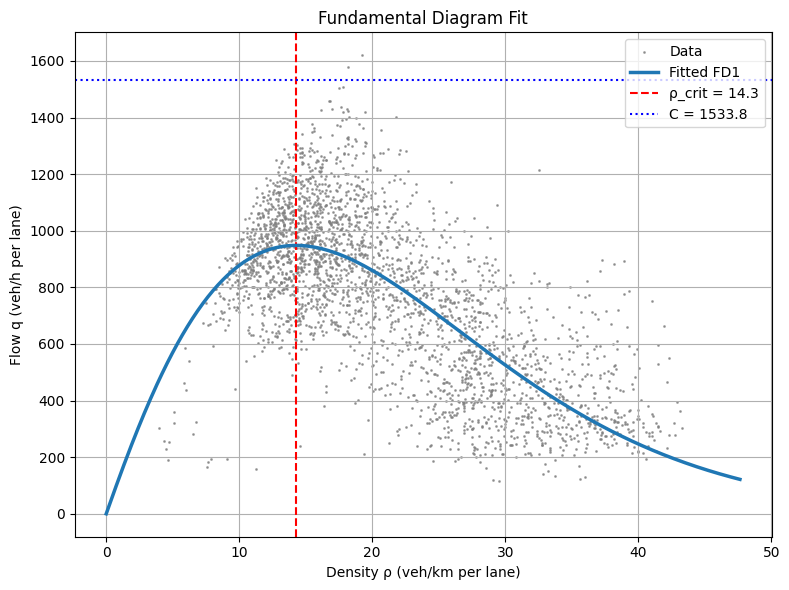

In [4]:
rho_crit = value(model.rho_crit)
V_free = value(model.V_free)
a = value(model.a)
C = np.mean(sorted(flattened_q_hat)[-5:])  # same C you used in Pyomo

# Define Q(rho) using the original piecewise FD1
def Q_fd1(rho):
    rho = np.array(rho)
    Q_free = V_free * rho * np.exp(-1/a * (rho / rho_crit)**a)
    # Q = np.where(rho <= rho_crit, Q_free, C)
    Q = Q_free
    return Q

# Generate smooth rho values for curve
rho_range = np.linspace(0, max(flattened_rho_hat)*1.1, 500)
q_fit = Q_fd1(rho_range)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(rho_hat, q_hat, color='gray', alpha=0.7, label='Data', s = 1)
plt.plot(rho_range, q_fit, linewidth=2.5, label='Fitted FD1', zorder=10)
plt.axvline(rho_crit, color='red', linestyle='--', label=f'ρ_crit = {rho_crit:.1f}')
plt.axhline(C, color='blue', linestyle=':', label=f'C = {C:.1f}')
plt.xlabel("Density ρ (veh/km per lane)")
plt.ylabel("Flow q (veh/h per lane)")
plt.title("Fundamental Diagram Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
def metanet_param_fit(v_hat, rho_hat, q_hat, v_free, a, rho_crit, T, l, initial_traffic_state, downstream_density, num_calibrated_segments):
    initial_flow_or = initial_traffic_state
    
    # print("vhat shape", v_hat.shape)
    num_timesteps, num_segments = v_hat.shape
    
    model = ConcreteModel()
    model.t = RangeSet(0, num_timesteps-1)
    model.i = RangeSet(0, num_segments-1)
    model.segment_ix = RangeSet(0, num_calibrated_segments-1)
    model.num_segments = num_segments
    # model.num_timesteps = num_timesteps
    model.num_calibrated_segments = num_calibrated_segments
    # Fixed params
    model.v_free = Param(initialize=v_free)
    model.a = Param(initialize=a)
    model.rho_crit = Param(initialize=rho_crit)
    model.T = Param(initialize=T)
    model.l = Param(initialize=l)

    # Parameters to estimate
    model.eta_high = Var(model.segment_ix, bounds=(10.0,90.0), initialize={seg_ix: float(30) for seg_ix in model.segment_ix})
    model.tau = Var(model.segment_ix, bounds=(5, 80.0), initialize={seg_ix: float(18/3600) for seg_ix in model.segment_ix})
    model.K = Var(model.segment_ix, bounds=(5.0, 50.0), initialize={seg_ix: float(40) for seg_ix in model.segment_ix})

    # Variables to predict
    model.v_pred = Var(model.t, model.i, bounds=(0, v_free+50), initialize={(t,i): float(v_hat[t, i]) for t in model.t for i in model.i})
    model.rho_pred = Var(model.t, model.i, bounds=(1e-3, 300), initialize={(t,i): float(rho_hat[t, i]) for t in model.t for i in model.i})
    model.q_pred = Var(model.t, model.i, bounds=(1e-3, 10000), initialize={(t,i): float(q_hat[t, i]) for t in model.t for i in model.i})
    
    model.constraints = ConstraintList()
    for i in range(num_segments):
        model.constraints.add(model.v_pred[0,i] == v_hat[0, i].item()) #velocity at first timestep, i velocity array of shape [num_segments]
        model.constraints.add(model.rho_pred[0,i] == rho_hat[0, i].item())
    # Observed data
   
    model.v_hat = Param(model.t, model.i, initialize={(t, i): float(v_hat[t, i]) for t in model.t for i in model.i})
    model.rho_hat = Param(model.t, model.i, initialize={(t, i): float(rho_hat[t, i]) for t in model.t for i in model.i})
    model.q_hat = Param(model.t, model.i, initialize={(t, i): float(q_hat[t, i]) for t in model.t for i in model.i})
    def density_dynamics(current, inflow, outflow, T, l):
        return current + T/(l) * (inflow - outflow)
    
    def calculate_V(m, rho, VSL):
        #V_free * rho * np.exp(-1/a * (rho / rho_crit)**a)
        # exp_term = m.v_free * rho * exp(-1/m.a * (rho/m.rho_crit)**m.a)
        exp_term = m.v_free * exp(-1 / m.a * (rho / m.rho_crit)**m.a)
        return exp_term
    
    def velocity_dynamics(m, current, prev_state, density, next_density, VSL, T, l, segment_num):
        tau = m.tau[segment_num]
        eta = m.eta_high[segment_num]
        K = m.K[segment_num]
        v_eq = calculate_V(m, density, VSL)
        term1 = T / tau * (v_eq - current)
        term2 = T / l * current * (prev_state - current)
        term3 = (eta * T) / (tau * l) * (next_density - density) / (density + K)
        return current + term1 + term2 - term3


    # Density dynamics
    def rho_update(m, t, i):
        calc_density = 0
        if t == 0:
            return Constraint.Skip
        if i == 0:
            current = m.rho_pred[t-1,0]
            inflow = initial_flow_or[t-1, 0]
            outflow = m.rho_pred[t-1, i] * m.v_pred[t-1, i]
            calc_density = density_dynamics(current, inflow, outflow, model.T, model.l)
        else:
            current = m.rho_pred[t-1,i]
            inflow = m.rho_pred[t-1, i-1] * m.v_pred[t-1, i-1]
            outflow = m.rho_pred[t-1, i] * m.v_pred[t-1, i]
            calc_density = density_dynamics(current, inflow, outflow, model.T, model.l)
        return m.rho_pred[t,i] == calc_density
    model.rho_dyn = Constraint(model.t, model.i, rule=rho_update)
    # model.constraints.add(Constraint(model.t, model.i, rule=rho_update))
    VSL = 150
    # Velocity dynamics
    def v_update(m, t, i):
        current_seg_num  = i // (m.num_segments // m.num_calibrated_segments)

        if t == 0:
            return Constraint.Skip
        if i == 0:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i]
            density = m.rho_pred[t-1, i]
            if( m.num_calibrated_segments == 1):
                next_density = downstream_density[t-1]
            else:
                next_density = m.rho_pred[t-1, i+1]
            calc_v = velocity_dynamics(m,current, prev_state, density, next_density, VSL, model.T, model.l, current_seg_num)
        elif i == num_segments-1:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i-1]
            density = m.rho_pred[t-1, i]
            next_density = downstream_density[t-1]
            calc_v = velocity_dynamics(m,current, prev_state, density, next_density, VSL, model.T, model.l, current_seg_num)
        else:
            current = m.v_pred[t-1, i]
            prev_state = m.v_pred[t-1, i-1]
            density = m.rho_pred[t-1, i]
            next_density = m.rho_pred[t-1, i+1]
            calc_v = velocity_dynamics(m, current, prev_state, density, next_density, VSL, model.T, model.l, current_seg_num)

        return m.v_pred[t,i] == calc_v
    model.v_dyn = Constraint(model.t, model.i, rule=v_update)

    # def q_update(m,t,i):
    #     if t == 0:
    #         return Constraint.Skip
    #     return m.q_pred[t,i] == m.v_pred[t,i] * m.rho_pred[t,i]
    # model.q_dyn = Constraint(model.t, model.i, rule=q_update)
    # model.constraints.add(Constraint(model.t, model.i, rule=v_update))

    # Objective: minimize squared error between predictions and observations
    def loss_fn(m):
        
        V_STD = np.std(v_hat)
        RHO_STD = np.std(rho_hat)
        Q_STD = np.std(q_hat)
        # return sum(((m.v_pred[t, i] - m.v_hat[t, i])/V_STD)**2
        #           for t in m.t for i in m.i)
        return sum(
            ((m.v_pred[t, i] - m.v_hat[t, i])**2)
            # ((m.rho_pred[t, i] - m.rho_hat[t, i]))**2)
            # +  ((m.v_pred[t, 3] - m.v_hat[t, 3])**2)
            for t in m.t for i in m.i
        )
        # return sum(
        #             ((m.q_pred[t,i] - m.q_hat[t,i])/Q_STD)**2 + 
        #             ((m.rho_pred[t, i] - m.rho_hat[t, i])/RHO_STD)**2 +
        #             ((m.v_pred[t, i] - m.v_hat[t, i])/V_STD)**2
        #           for t in m.t for i in m.i)
    model.loss = Objective(rule=loss_fn, sense=minimize)

    # Solve
    solver = SolverFactory("ipopt")
    solver.options['max_iter'] = 20000 
    solver.solve(model, tee=False)
    return model

In [6]:
# Calculate flow and speed for 100 meter segments
MILE_MARKER_61 = 60.21 * 5280 * 0.3048 #meters
MILE_MARKER_62 = 62.29 * 5280 * 0.3048 # 2800 meters
def smooth_inflow(inflow, window_size=1):
    kernel = np.ones(window_size) / window_size
    smoothed = np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='same'), axis=0, arr=inflow)
    return smoothed
    
l = 400
time_segments = np.arange(0,3600, 10)
num_timesteps = len(time_segments)
num_segments = 6
T = 10/3600
l = 0.4
SPEED_LIMIT = 150 # KM/H
for t in range(num_timesteps):
    for i in range(num_segments):
        if rho_hat[t,i] == 0.0:
            rho_hat[t,i] = 1e-3
print(np.min(rho_hat))
# q_hat = smooth_inflow(q_hat)
# rho_hat = smooth_inflow(rho_hat)
v_hat = q_hat/rho_hat

num_calibrated_segments = 6
print("q_hat shape", q_hat.shape)

initial_flow = q_hat[:, 0:1]

initial_flow = smooth_inflow(initial_flow)
initial_traffic_state = initial_flow
segment_rho_hat = rho_hat[:, 1:7]       # shape (time, segment)
segment_v_hat = v_hat[:, 1:7]
segment_q_hat = q_hat[:, 1:7]
downstream_density = rho_hat[:, 7:8]
downstream_density = smooth_inflow(downstream_density)
np.save('initial_flow.npy', initial_flow)
np.save('downstream_density.npy', downstream_density)

# Transpose before passing
res_model = metanet_param_fit(
    segment_v_hat,
    segment_rho_hat,
    segment_q_hat,
    V_free, a, rho_crit, T, l,
    initial_traffic_state, downstream_density,
    num_calibrated_segments
)
num_timesteps, num_segments = segment_v_hat.shape

v_pred_array = np.zeros((num_timesteps, num_segments))
rho_pred_array = np.zeros((num_timesteps, num_segments))

# Fill arrays with values from the Pyomo model
for t in range(num_timesteps):  # Pyomo index starts at 1
    for i in range(num_segments):
        v_pred_array[t, i] = value(res_model.v_pred[t, i])
        rho_pred_array[t, i] = value(res_model.rho_pred[t, i])

for seg in range(num_calibrated_segments):
    print("Segment", seg)
    print("tau:", value(res_model.tau[seg]))
    print("K:", value(res_model.K[seg]))
    print("eta high", value(res_model.eta_high[seg]))
    print("------------")


3.9349994374999993
q_hat shape (360, 8)
WARNING (W1002): Setting Var 'tau[0]' to a numeric value `0.005` outside the
bounds (5, 80.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'tau[1]' to a numeric value `0.005` outside the
bounds (5, 80.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'tau[2]' to a numeric value `0.005` outside the
bounds (5, 80.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'tau[3]' to a numeric value `0.005` outside the
bounds (5, 80.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'tau[4]' to a numeric value `0.005` outside the
bounds (5, 80.0).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'tau[5]' to a numeric value `0.005` outside the
bounds (5, 80.0).
    See also https://pyomo.readthedocs.i

(360, 6)


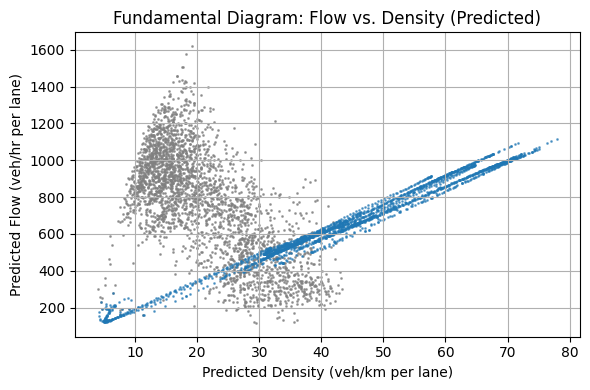

In [7]:
# Extract shape
q_array = rho_pred_array * v_pred_array
print(q_array.shape)
# Plot
plt.figure(figsize=(6, 4))
# plt.plot(rho_range, q_fit, linewidth=2.5, label='Fitted FD1', zorder=10)
plt.scatter(rho_hat[:,:], q_hat[:,:], color='gray', alpha=0.7,s = 1, label='Data')
plt.scatter(rho_pred_array, q_array, alpha=0.6, s=1)
plt.xlabel("Predicted Density (veh/km per lane)")
plt.ylabel("Predicted Flow (veh/hr per lane)")
plt.title("Fundamental Diagram: Flow vs. Density (Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
import numpy as np

def mape(flow_hat, flow_pred):
    """
    Compute the Mean Absolute Percentage Error (MAPE) between ground truth and prediction.

    Parameters:
        flow_hat (np.ndarray): Ground truth array of shape [t, i]
        flow_pred (np.ndarray): Predicted array of shape [t, i]

    Returns:
        float: The mean absolute percentage error (in percent)
    """
    # Avoid division by zero by masking out zero ground truth values
    mask = flow_hat != 0
    # print(flow_hat.shape)
    # print(flow_pred.shape)
    error = np.abs((flow_pred[mask] - flow_hat[mask]) / flow_hat[mask])
    return np.mean(error) * 100
def rmse(flow_hat, flow_pred):
    """
    Compute the Root Mean Squared Error (RMSE) between ground truth and prediction.

    Parameters:
        flow_hat (np.ndarray): Ground truth array of shape [t, i]
        flow_pred (np.ndarray): Predicted array of shape [t, i]

    Returns:
        float: The root mean squared error
    """
    error = flow_pred - flow_hat
    mse = np.mean(np.square(error))
    return np.sqrt(mse)


In [9]:

print("rho mape", mape(rho_hat[:,1:-1], rho_pred_array))
print("q mape", mape(q_hat[:, 1:-1], q_array))
print("v mape", mape(v_hat[:, 1:-1], v_pred_array))
print("----------------")
print("rho rmse", rmse(rho_hat[:,1:-1], rho_pred_array))
print("q rmse", rmse(q_hat[:, 1:-1], q_array))
print("v rmse", rmse(v_hat[:, 1:-1], v_pred_array))

rho mape 159.4888049086776
q mape 47.30641015414836
v mape 64.40469197558197
----------------
rho rmse 30.366822694904315
q rmse 355.76687685774266
v rmse 39.79708657663184


43.317499125000005


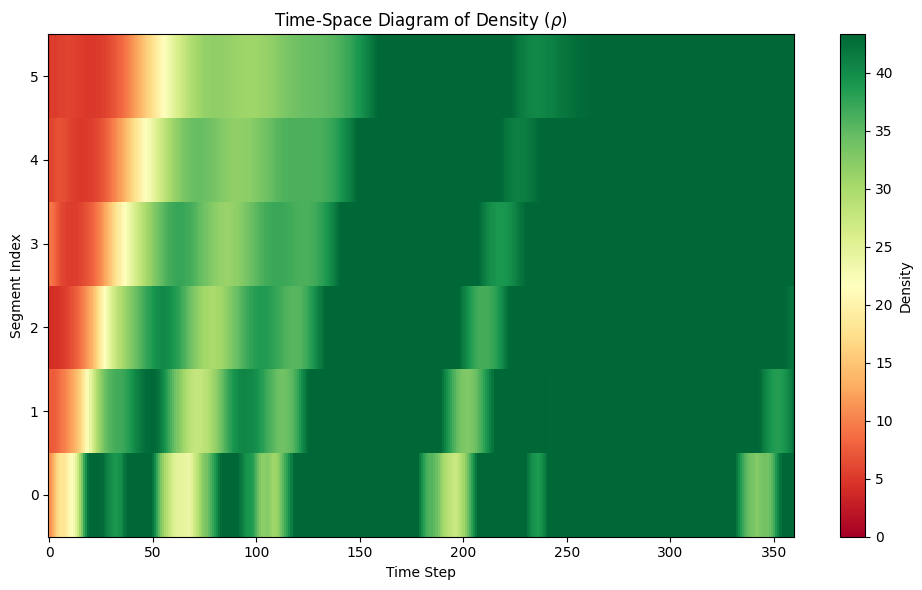

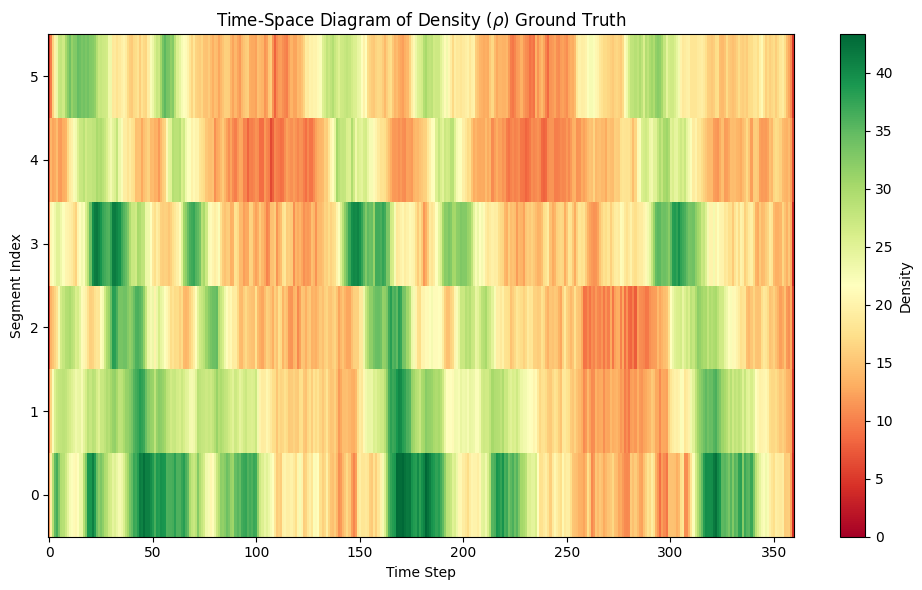

In [10]:
rho_plot =rho_pred_array
plt.figure(figsize=(10, 6))
plt.imshow(rho_plot.T, aspect='auto', origin='lower', cmap='RdYlGn', interpolation = "none", vmin = 0, vmax = 43.317499125000005
)

# Label axes
plt.xlabel('Time Step')
plt.ylabel('Segment Index')
plt.title('Time-Space Diagram of Density ($\\rho$)')
plt.colorbar(label='Density')

plt.tight_layout()
# plt.show()

rho_plot =rho_hat[:, 1:-1]
print(np.max(rho_plot))
plt.figure(figsize=(10, 6))
plt.imshow(rho_plot.T, aspect='auto', origin='lower', cmap='RdYlGn', interpolation = "none", vmin = 0, vmax = 43.317499125000005
)

# Label axes
plt.xlabel('Time Step')
plt.ylabel('Segment Index')
plt.title('Time-Space Diagram of Density ($\\rho$) Ground Truth')
plt.colorbar(label='Density')

plt.tight_layout()
# plt.show()

102.8597127697313
102.8597127697313


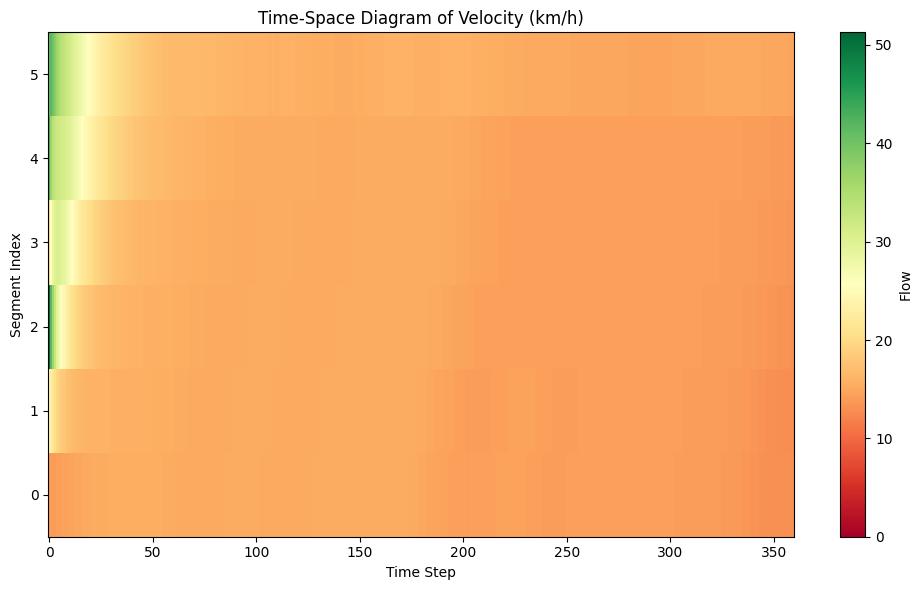

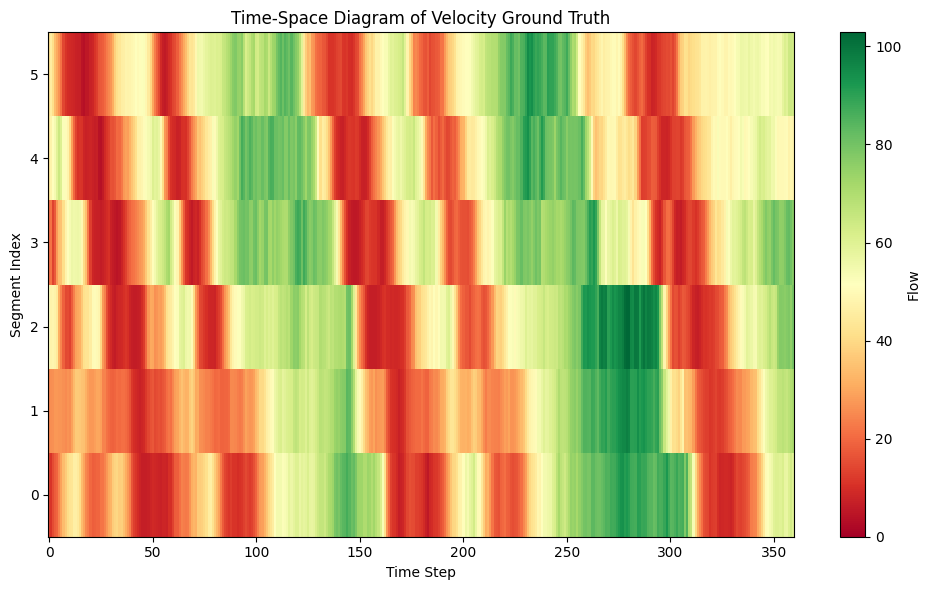

In [11]:
rho_plot =v_pred_array
vmax = print(np.max(v_hat))
plt.figure(figsize=(10, 6))
plt.imshow(rho_plot.T, aspect='auto', origin='lower', cmap='RdYlGn', interpolation="none", vmin = 0, vmax = vmax)

# Label axes
plt.xlabel('Time Step')
plt.ylabel('Segment Index')
plt.title('Time-Space Diagram of Velocity (km/h)')
plt.colorbar(label='Flow')

plt.tight_layout()
# plt.show()

rho_plot =v_hat[:, 1:-1]
print(np.max(v_hat))
plt.figure(figsize=(10, 6))
plt.imshow(rho_plot.T, aspect='auto', origin='lower', cmap='RdYlGn', interpolation="none", vmin = 0, vmax = vmax)

# Label axes
plt.xlabel('Time Step')
plt.ylabel('Segment Index')
plt.title('Time-Space Diagram of Velocity Ground Truth')
plt.colorbar(label='Flow')

plt.tight_layout()
# plt.show()

1619.9142750000112


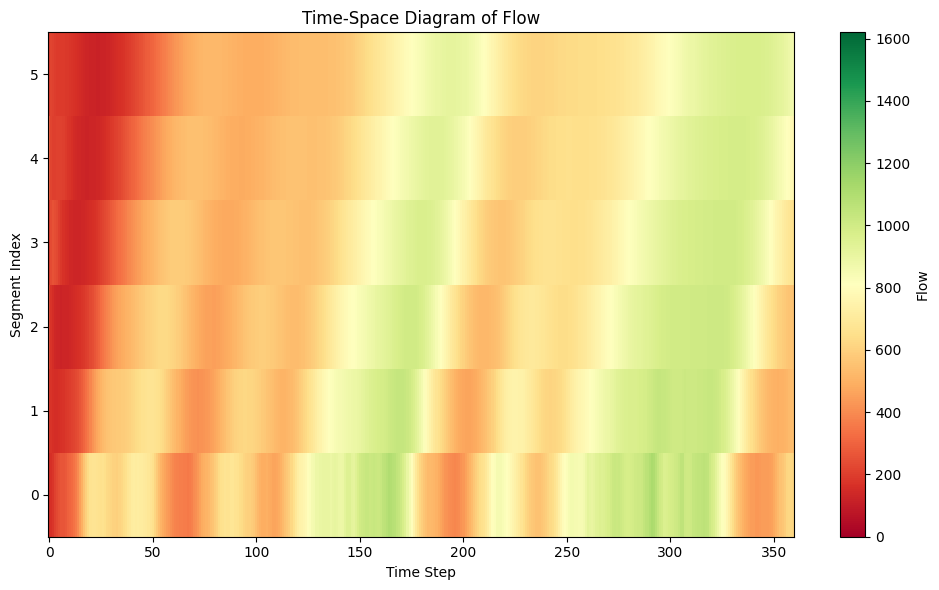

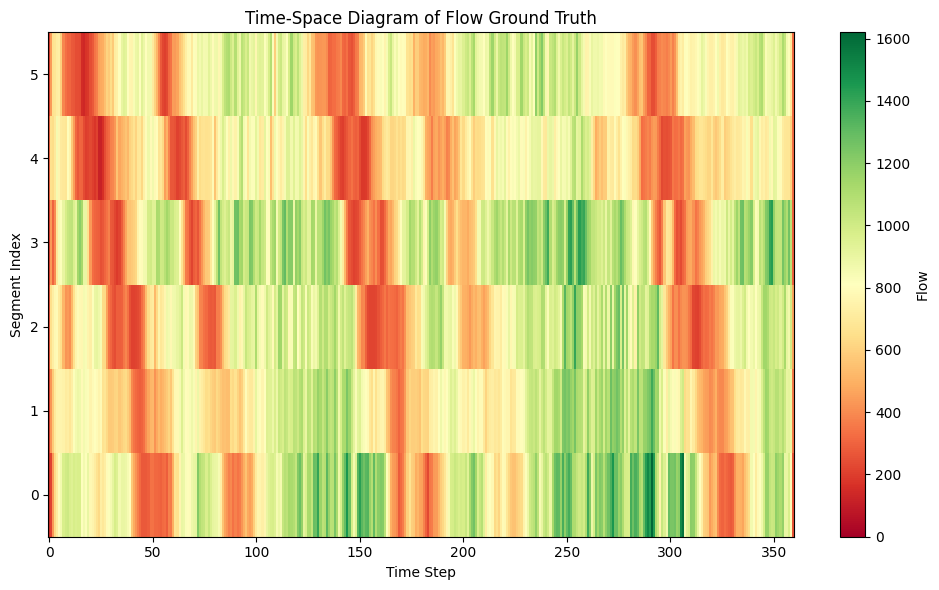

In [12]:
rho_plot = q_array
plt.figure(figsize=(10, 6))
plt.imshow(rho_plot.T, aspect='auto', origin='lower', cmap='RdYlGn', interpolation="none", vmin = 0, vmax = 1619.9142750000112)

# Label axes
plt.xlabel('Time Step')
plt.ylabel('Segment Index')
plt.title('Time-Space Diagram of Flow')
plt.colorbar(label='Flow')

plt.tight_layout()
# plt.show()

rho_plot =q_hat[:, 1:-1]
print(np.max(rho_plot))
plt.figure(figsize=(10, 6))
plt.imshow(rho_plot.T, aspect='auto', origin='lower', cmap='RdYlGn', interpolation="none", vmin = 0, vmax = 1619.9142750000112)

# Label axes
plt.xlabel('Time Step')
plt.ylabel('Segment Index')
plt.title('Time-Space Diagram of Flow Ground Truth')
plt.colorbar(label='Flow')

plt.tight_layout()
# plt.show()